<a href="https://colab.research.google.com/github/afifaniks/TomatoLeafDiseaseDetection/blob/master/Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp 'drive/My Drive/Leaf Disease/Data_3.zip' .

In [3]:
!unzip Data_3.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data_3/Train/Tomato_Late_Blight/bd4f09bd-ee85-4ab1-bce0-8cde3fdd7f1b___GHLB_PS Leaf 23.7 Day 13.jpg  
  inflating: Data_3/Train/Tomato_Late_Blight/bd5a4716-1cf0-46d3-a905-320e4d84d34a___RS_Late.B 6199.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/bd5b09dc-ca07-455b-9ff4-e02a5c7e8a42___RS_Late.B 6202.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/bd10f32e-3a27-4a58-9def-62555e99b223___RS_Late.B 6768.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/bd9341f4-34d9-4acb-9aa0-5dbff08f8ba6___GHLB_PS Leaf 23 Day 9.jpg  
  inflating: Data_3/Train/Tomato_Late_Blight/be2cc67b-7311-47a4-bcf7-bf62bf429533___GHLB2 Leaf 9008.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/be5c294b-38cc-44b8-b404-ab7d899cb717___GHLB2 Leaf 161.1.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/be9f181f-5692-4811-9678-69dbe94d6ecc___RS_Late.B 4838.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/be22c9d7-82af-4062-89c3-24cc59d461dd___GHLB 

In [4]:
%tensorflow_version 1.15
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import keras
from keras.preprocessing import image
import numpy as np

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


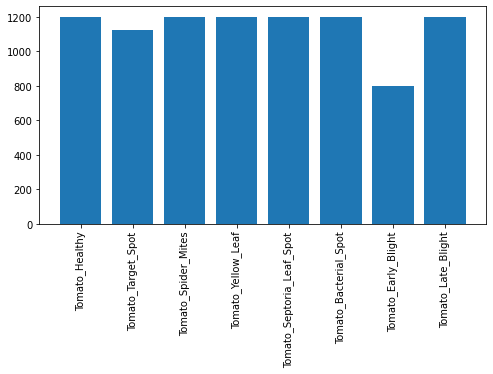

In [5]:
data_folder = 'Data_3/Train'
directory = os.listdir(data_folder)

file_counts = {}
for d in directory:
    file_counts[d] = len(os.listdir(os.path.join(data_folder, d)))
    
# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(file_counts.keys(), file_counts.values())
plt.xticks(rotation='vertical')
plt.show()

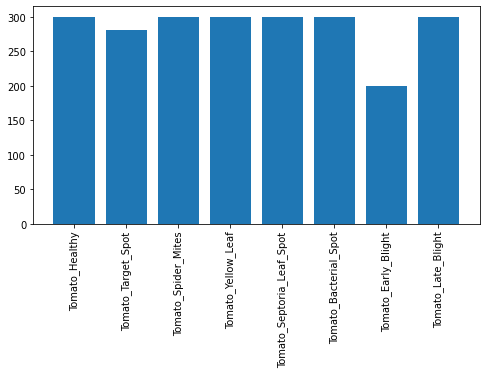

In [6]:
data_folder = 'Data_3/Test'
directory = os.listdir(data_folder)

file_counts = {}
for d in directory:
    file_counts[d] = len(os.listdir(os.path.join(data_folder, d)))
    
# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(file_counts.keys(), file_counts.values())
plt.xticks(rotation='vertical')
plt.show()

In [7]:
image = plt.imread('Data_3/Train/Tomato_Bacterial_Spot/0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_Bact.Sp 6254.JPG')
image.shape

(256, 256, 3)

In [8]:
# Image preprocessing
img_height = image.shape[0]
img_width = image.shape[1]

train_data_dir = 'Data_3/Train'
test_data_dir = 'Data_3/Test'

epochs = 50
batch_size = 20
batch_dim = -1

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_height, img_width)
    batch_dim = 1
else:
    input_shape = (img_height, img_width, 3)

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, rotation_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_generator = train_datagen.flow_from_directory(test_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 9124 images belonging to 8 classes.
Found 2280 images belonging to 8 classes.


In [9]:
train_size = len(train_generator.labels)
test_size = len(test_generator.labels)

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=batch_dim))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(Dropout(0.2))

model.add(Dense(8))
model.add(Activation(activation='softmax'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
______________________________________

In [11]:
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('plants.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [12]:
!pip install keras-unet
!pip install extra_keras_metrics

  Created wheel for extra-keras-metrics: filename=extra_keras_metrics-1.3.1-cp36-none-any.whl size=13091 sha256=ee476c0575ad07a784913668571efab4eae0d1b1de68c6e760993d55a9656a27
  Stored in directory: /root/.cache/pip/wheels/48/f1/b4/a9f81578416b99274b6d5b34fdc92d9bd82b6be99efa965b17
Successfully built extra-keras-metrics


In [13]:
from keras_unet.metrics import iou, iou_thresholded, dice_coef
import extra_keras_metrics as ekm

-----------------------------------------
keras-unet init: TF version is < 2.0.0 or not present - using `Keras` instead of `tf.keras`
-----------------------------------------


In [14]:
# metrics=["accuracy", iou, iou_thresholded, dice_coef, ekm.precision, ekm.recall]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
results = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=np.ceil(train_size/batch_size), validation_data=test_generator, validation_steps=np.ceil(test_size/batch_size), callbacks=callbacks)


Epoch 1/50
457/457 [==============================] - 166s 363ms/step - loss: 0.7834 - accuracy: 0.7327 - val_loss: 4.7090 - val_accuracy: 0.2307

Epoch 00001: val_loss improved from inf to 4.70899, saving model to plants.h5
Epoch 2/50
457/457 [==============================] - 158s 345ms/step - loss: 0.5594 - accuracy: 0.8114 - val_loss: 1.1071 - val_accuracy: 0.6474

Epoch 00002: val_loss improved from 4.70899 to 1.10705, saving model to plants.h5
Epoch 3/50
457/457 [==============================] - 158s 346ms/step - loss: 0.3749 - accuracy: 0.8735 - val_loss: 1.3033 - val_accuracy: 0.5658

Epoch 00003: val_loss did not improve from 1.10705
Epoch 4/50
457/457 [==============================] - 158s 346ms/step - loss: 0.3265 - accuracy: 0.8862 - val_loss: 0.9541 - val_accuracy: 0.6741

Epoch 00004: val_loss improved from 1.10705 to 0.95412, saving model to plants.h5
Epoch 5/50
457/457 [==============================] - 158s 345ms/step - loss: 0.3144 - accuracy: 0.8965 - val_loss: 0.

In [15]:
results.history['accuracy']

[0.73268306,
 0.8113766,
 0.8735204,
 0.8862341,
 0.8965366,
 0.9055239,
 0.91889524,
 0.91484,
 0.9260193,
 0.9358834,
 0.9410346,
 0.93029374,
 0.94651467,
 0.95385796,
 0.9686541,
 0.97479177,
 0.9775318,
 0.9780798,
 0.98191583,
 0.98257345,
 0.9838886,
 0.9853135,
 0.9854231,
 0.98454624,
 0.9865191,
 0.9853135,
 0.9854231,
 0.9869575,
 0.98553264,
 0.98662865,
 0.98673826,
 0.98827267,
 0.98673826,
 0.9881631,
 0.98717666,
 0.98662865,
 0.98717666,
 0.9868479,
 0.98476547,
 0.9864095,
 0.9873959,
 0.9876151,
 0.9879439,
 0.9875055,
 0.9870671,
 0.98673826,
 0.98553264,
 0.98673826,
 0.9881631,
 0.9869575]

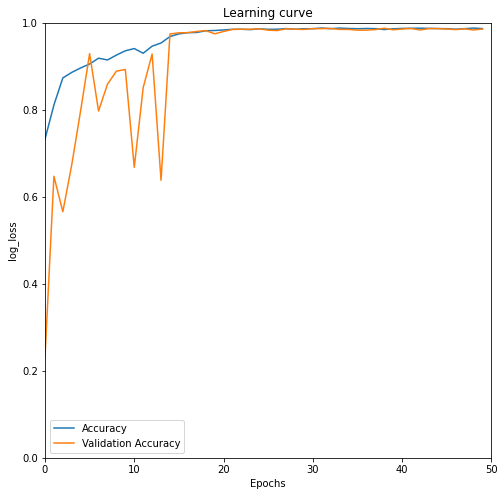

In [16]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.plot(results.history['accuracy'], label="Accuracy")
plt.plot(results.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

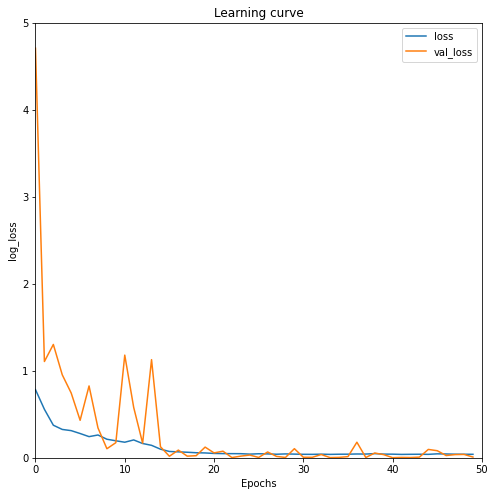

In [22]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.xlim(0, 50)
plt.ylim(0, 5)
plt.plot(results.history['loss'], label="loss")
plt.plot(results.history['val_loss'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
model.evaluate()

In [18]:
print("Good Job Anik! Trivial! Yet, nicely put!") #SNP

Good Job Anik! Trivial! Yet, nicely put!
